DataFrame shape: (40, 73)
DataFrame columns: ['Frame', '49@SG_x', '49@HG1_x', '49@CB_x', '49@HB1_x', '49@HB2_x', '49@CA_x', '49@HA_x', '49@N_x', '49@HN_x', '196@O1_x', '196@O2_x', '196@H1_x', '196@H2_x', '83@NE2_x', '83@HE21_x', '83@HE22_x', '83@CD_x', '83@OE1_x', '83@CB_x', '83@HB1_x', '83@HB2_x', '83@CG_x', '83@HG1_x', '83@HG2_x', '49@SG_y', '49@HG1_y', '49@CB_y', '49@HB1_y', '49@HB2_y', '49@CA_y', '49@HA_y', '49@N_y', '49@HN_y', '196@O1_y', '196@O2_y', '196@H1_y', '196@H2_y', '83@NE2_y', '83@HE21_y', '83@HE22_y', '83@CD_y', '83@OE1_y', '83@CB_y', '83@HB1_y', '83@HB2_y', '83@CG_y', '83@HG1_y', '83@HG2_y', '49@SG_z', '49@HG1_z', '49@CB_z', '49@HB1_z', '49@HB2_z', '49@CA_z', '49@HA_z', '49@N_z', '49@HN_z', '196@O1_z', '196@O2_z', '196@H1_z', '196@H2_z', '83@NE2_z', '83@HE21_z', '83@HE22_z', '83@CD_z', '83@OE1_z', '83@CB_z', '83@HB1_z', '83@HB2_z', '83@CG_z', '83@HG1_z', '83@HG2_z']
First few rows:
   Frame    49@SG_x   49@HG1_x    49@CB_x   49@HB1_x   49@HB2_x    49@CA_x  \
0      0  3

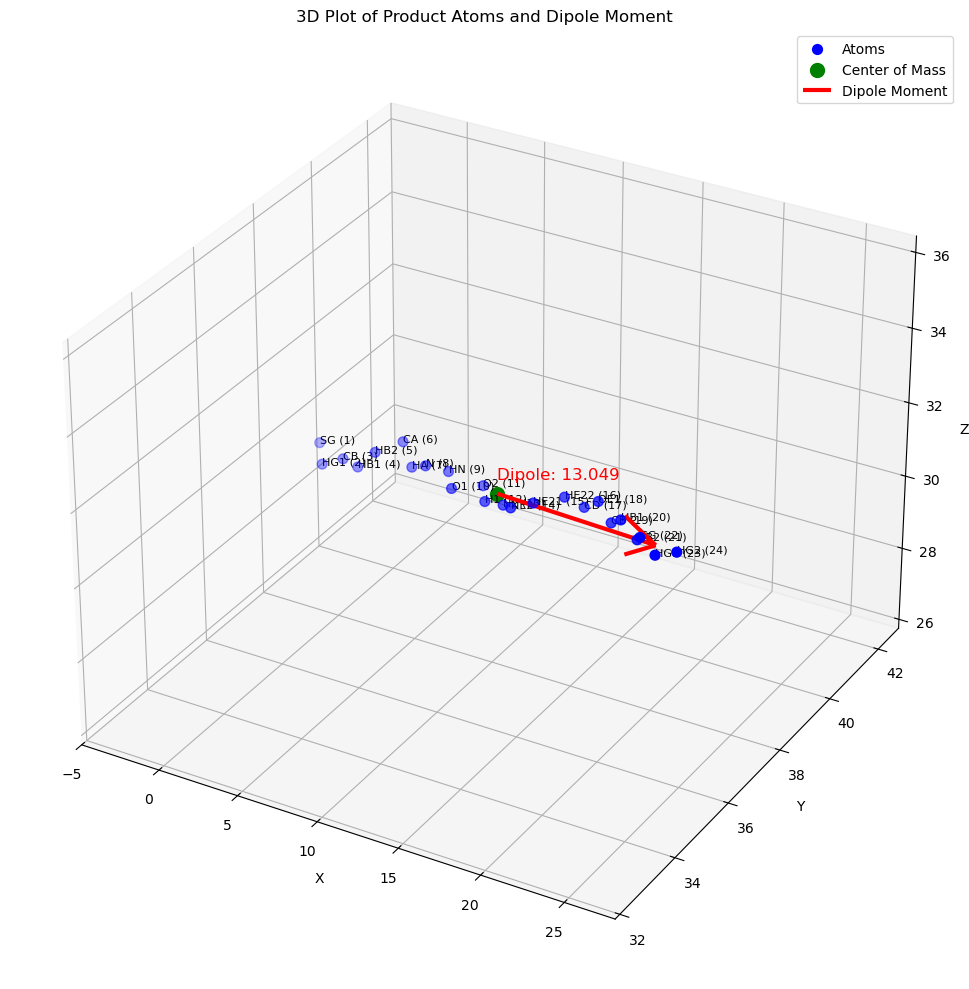

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Load product coordinates
product_data = pd.read_csv("/home/hp/results/MOUSE/level1/F139L/replica000/product.csv")

# Print the first few rows to understand the structure
print("DataFrame shape:", product_data.shape)
print("DataFrame columns:", product_data.columns.tolist())
print("First few rows:")
print(product_data.head())

# Define charges for the product state (ensure this matches your atom count)
charges_product = {
    1: -0.9, 2: 0.418, 3: -0.3, 4: 0.1, 5: 0.1, 6: 0.14, 7: 0.06, 8: -0.5, 9: 0.3,
    10: -0.418, 11: -0.418, 12: 0.418, 13: 0.418, 14: -0.4965, 15: 0.48, 16: 0.48, 17: 0.2858,
    18: -0.503, 19: -0.12, 20: 0.06, 21: 0.06, 22: 0.2157, 23: 0.06, 24: 0.06
}

# STEP 1: First determine the correct format of your coordinates
# Assuming the second, third, and fourth columns contain x, y, z coordinates
try:
    if 'x' in product_data.columns and 'y' in product_data.columns and 'z' in product_data.columns:
        x_col, y_col, z_col = 'x', 'y', 'z'
    else:
        numerical_cols = product_data.select_dtypes(include=[np.number]).columns
        if len(numerical_cols) >= 3:
            x_col, y_col, z_col = numerical_cols[:3]
        else:
            x_col, y_col, z_col = product_data.columns[1], product_data.columns[2], product_data.columns[3]
    
    print(f"Using columns: {x_col}, {y_col}, {z_col} for coordinates")
    
    # Extract coordinates properly
    coordinates = np.array([
        product_data[x_col].values,
        product_data[y_col].values,
        product_data[z_col].values
    ]).T  # Transpose to get (n_atoms, 3) shape
    
    print("Coordinates shape:", coordinates.shape)
    print("First few coordinates:")
    print(coordinates[:5])

except Exception as e:
    print(f"Error extracting coordinates: {e}")
    print("Trying alternative approach...")
    
    numerical_data = product_data.select_dtypes(include=[np.number]).values
    if numerical_data.shape[1] % 3 == 0:
        n_atoms = numerical_data.shape[1] // 3
        coordinates = numerical_data.reshape(-1, 3)
        print(f"Reshaped to {coordinates.shape}")
    else:
        coordinates = product_data.iloc[:, 1:4].values
        print(f"Using first 3 data columns, shape: {coordinates.shape}")

# Ensure that the number of coordinates matches the number of charges
num_atoms = len(coordinates)
num_charges = len(charges_product)

print(f"Number of atoms: {num_atoms}, Number of charges: {num_charges}")

if num_atoms > num_charges:
    print(f"Warning: More atoms ({num_atoms}) than charges ({num_charges}). Using only the first {num_charges} atoms.")
    coordinates = coordinates[:num_charges]
elif num_atoms < num_charges:
    print(f"Warning: Fewer atoms ({num_atoms}) than charges ({num_charges}). Using only the first {num_atoms} charges.")
    charges_subset = {i+1: charges_product[i+1] for i in range(num_atoms)}
    charges_product = charges_subset

# Calculate center of mass
center_of_mass = np.mean(coordinates, axis=0)
print("Center of Mass:", center_of_mass)

# Calculate dipole moment relative to center of mass
dipole_moment = np.zeros(3)
for i in range(len(coordinates)):
    r_i = coordinates[i] - center_of_mass
    dipole_moment += charges_product[i+1] * r_i

# Calculate dipole moment magnitude
dipole_magnitude = np.linalg.norm(dipole_moment)
print("Dipole Moment Vector:", dipole_moment)
print("Dipole Moment Magnitude:", dipole_magnitude)

# Atom names for product state (example, adjust as needed)
atom_names_product = [
    "SG", "HG1", "CB", "HB1", "HB2", "CA", "HA", "N", "HN", 
    "O1", "O2", "H1", "H2", "NE2", "HE21", "HE22", "CD", "OE1", 
    "CB", "HB1", "HB2", "CG", "HG1", "HG2"
]

# Create a 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot atoms
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2], color='blue', s=50, label='Atoms')

# Set axis limits
x_min, x_max = min(coordinates[:, 0]), max(coordinates[:, 0])
y_min, y_max = min(coordinates[:, 1]), max(coordinates[:, 1])
z_min, z_max = min(coordinates[:, 2]), max(coordinates[:, 2])

# Add some padding
padding = 5
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)
ax.set_zlim(z_min - padding, z_max + padding)

# Add atom names as labels
for i in range(len(coordinates)):
    ax.text(coordinates[i, 0], coordinates[i, 1], coordinates[i, 2], f"{atom_names_product[i]} ({i+1})", fontsize=8)

# Plot center of mass
ax.scatter([center_of_mass[0]], [center_of_mass[1]], [center_of_mass[2]], 
           color='green', s=100, marker='o', label='Center of Mass')

# Make dipole moment vector visible
scale_factor = max(10.0, 10.0 / max(dipole_magnitude, 0.001))
ax.quiver(center_of_mass[0], center_of_mass[1], center_of_mass[2], 
         dipole_moment[0], dipole_moment[1], dipole_moment[2], 
         color='red', linewidth=3, length=scale_factor, normalize=True,
         arrow_length_ratio=0.2, label='Dipole Moment')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Plot of Product Atoms and Dipole Moment')

# Add text with dipole moment value
text_pos = [center_of_mass[0], center_of_mass[1], z_max]
ax.text(text_pos[0], text_pos[1], text_pos[2], 
        f'Dipole: {dipole_magnitude:.3f}', 
        fontsize=12, color='red')

# Add a legend
ax.legend()

# Add grid for better visualization
ax.grid(True)

# Show the plot
plt.tight_layout()
#plt.savefig('product_dipole_plot.png', dpi=300, bbox_inches='tight')
plt.show()
